In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701992, 828)
(701992, 1)
validation
(107232, 828)
(107232, 1)
test
(76096, 828)
(76096, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:49 - loss: 0.0583 - STD: 4.8749e-04 - MAE: 0.2312

 4/71 [>.............................] - ETA: 1s - loss: 0.0330 - STD: 5.1331e-04 - MAE: 0.1376  

 5/71 [=>............................] - ETA: 2s - loss: 0.0331 - STD: 4.5889e-04 - MAE: 0.1381

 6/71 [=>............................] - ETA: 2s - loss: 0.0327 - STD: 4.2371e-04 - MAE: 0.1367

 7/71 [=>............................] - ETA: 2s - loss: 0.0318 - STD: 4.1006e-04 - MAE: 0.1330

 8/71 [==>...........................] - ETA: 3s - loss: 0.0303 - STD: 4.1443e-04 - MAE: 0.1268

 9/71 [==>...........................] - ETA: 3s - loss: 0.0286 - STD: 4.3334e-04 - MAE: 0.1201

10/71 [===>..........................] - ETA: 3s - loss: 0.0271 - STD: 4.6192e-04 - MAE: 0.1161

11/71 [===>..........................] - ETA: 3s - loss: 0.0261 - STD: 4.9470e-04 - MAE: 0.1151

12/71 [====>.........................] - ETA: 3s - loss: 0.0255 - STD: 5.2931e-04 - MAE: 0.1156

13/71 [====>.........................] - ETA: 3s - loss: 0.0252 - STD: 5.6356e-04 - MAE: 0.1166

14/71 [====>.........................] - ETA: 3s - loss: 0.0248 - STD: 5.9848e-04 - MAE: 0.1171

15/71 [=====>........................] - ETA: 3s - loss: 0.0243 - STD: 6.3227e-04 - MAE: 0.1166

16/71 [=====>........................] - ETA: 3s - loss: 0.0237 - STD: 6.6532e-04 - MAE: 0.1151

17/71 [======>.......................] - ETA: 3s - loss: 0.0231 - STD: 6.9582e-04 - MAE: 0.1129

18/71 [======>.......................] - ETA: 3s - loss: 0.0227 - STD: 7.2461e-04 - MAE: 0.1106

19/71 [=======>......................] - ETA: 3s - loss: 0.0223 - STD: 7.5122e-04 - MAE: 0.1083

20/71 [=======>......................] - ETA: 2s - loss: 0.0220 - STD: 7.7676e-04 - MAE: 0.1063

21/71 [=======>......................] - ETA: 2s - loss: 0.0217 - STD: 8.0221e-04 - MAE: 0.1045

22/71 [========>.....................] - ETA: 2s - loss: 0.0215 - STD: 8.2914e-04 - MAE: 0.1029

23/71 [========>.....................] - ETA: 2s - loss: 0.0212 - STD: 8.5733e-04 - MAE: 0.1014

24/71 [=========>....................] - ETA: 2s - loss: 0.0210 - STD: 8.8885e-04 - MAE: 0.1000

25/71 [=========>....................] - ETA: 2s - loss: 0.0207 - STD: 9.2329e-04 - MAE: 0.0987

26/71 [=========>....................] - ETA: 2s - loss: 0.0204 - STD: 9.6178e-04 - MAE: 0.0977

27/71 [==========>...................] - ETA: 2s - loss: 0.0202 - STD: 0.0010 - MAE: 0.0970    

28/71 [==========>...................] - ETA: 2s - loss: 0.0200 - STD: 0.0010 - MAE: 0.0967

29/71 [===========>..................] - ETA: 2s - loss: 0.0198 - STD: 0.0011 - MAE: 0.0964

30/71 [===========>..................] - ETA: 2s - loss: 0.0196 - STD: 0.0011 - MAE: 0.0963

31/71 [============>.................] - ETA: 2s - loss: 0.0194 - STD: 0.0012 - MAE: 0.0962

32/71 [============>.................] - ETA: 2s - loss: 0.0193 - STD: 0.0012 - MAE: 0.0961

33/71 [============>.................] - ETA: 2s - loss: 0.0192 - STD: 0.0013 - MAE: 0.0958

34/71 [=============>................] - ETA: 2s - loss: 0.0190 - STD: 0.0014 - MAE: 0.0953

35/71 [=============>................] - ETA: 2s - loss: 0.0189 - STD: 0.0014 - MAE: 0.0947

36/71 [==============>...............] - ETA: 2s - loss: 0.0187 - STD: 0.0015 - MAE: 0.0941

37/71 [==============>...............] - ETA: 2s - loss: 0.0186 - STD: 0.0015 - MAE: 0.0934

38/71 [===============>..............] - ETA: 1s - loss: 0.0185 - STD: 0.0016 - MAE: 0.0928

39/71 [===============>..............] - ETA: 1s - loss: 0.0184 - STD: 0.0017 - MAE: 0.0922

40/71 [===============>..............] - ETA: 1s - loss: 0.0183 - STD: 0.0017 - MAE: 0.0916

41/71 [================>.............] - ETA: 1s - loss: 0.0182 - STD: 0.0018 - MAE: 0.0911

42/71 [================>.............] - ETA: 1s - loss: 0.0180 - STD: 0.0019 - MAE: 0.0906

43/71 [=================>............] - ETA: 1s - loss: 0.0179 - STD: 0.0020 - MAE: 0.0902

44/71 [=================>............] - ETA: 1s - loss: 0.0178 - STD: 0.0021 - MAE: 0.0899

45/71 [==================>...........] - ETA: 1s - loss: 0.0177 - STD: 0.0022 - MAE: 0.0896

46/71 [==================>...........] - ETA: 1s - loss: 0.0176 - STD: 0.0023 - MAE: 0.0894

47/71 [==================>...........] - ETA: 1s - loss: 0.0175 - STD: 0.0025 - MAE: 0.0892

48/71 [===================>..........] - ETA: 1s - loss: 0.0174 - STD: 0.0026 - MAE: 0.0890

49/71 [===================>..........] - ETA: 1s - loss: 0.0173 - STD: 0.0028 - MAE: 0.0888

50/71 [====================>.........] - ETA: 1s - loss: 0.0172 - STD: 0.0029 - MAE: 0.0885

51/71 [====================>.........] - ETA: 1s - loss: 0.0171 - STD: 0.0031 - MAE: 0.0882

52/71 [====================>.........] - ETA: 1s - loss: 0.0170 - STD: 0.0033 - MAE: 0.0878

53/71 [=====================>........] - ETA: 1s - loss: 0.0170 - STD: 0.0035 - MAE: 0.0874

54/71 [=====================>........] - ETA: 1s - loss: 0.0169 - STD: 0.0038 - MAE: 0.0870

55/71 [======================>.......] - ETA: 0s - loss: 0.0168 - STD: 0.0040 - MAE: 0.0866

56/71 [======================>.......] - ETA: 0s - loss: 0.0167 - STD: 0.0043 - MAE: 0.0863

57/71 [=======================>......] - ETA: 0s - loss: 0.0166 - STD: 0.0046 - MAE: 0.0859

58/71 [=======================>......] - ETA: 0s - loss: 0.0165 - STD: 0.0050 - MAE: 0.0856

59/71 [=======================>......] - ETA: 0s - loss: 0.0164 - STD: 0.0054 - MAE: 0.0853

60/71 [========================>.....] - ETA: 0s - loss: 0.0162 - STD: 0.0058 - MAE: 0.0850

61/71 [========================>.....] - ETA: 0s - loss: 0.0161 - STD: 0.0063 - MAE: 0.0846

62/71 [=========================>....] - ETA: 0s - loss: 0.0160 - STD: 0.0068 - MAE: 0.0843

63/71 [=========================>....] - ETA: 0s - loss: 0.0159 - STD: 0.0074 - MAE: 0.0839

64/71 [==========================>...] - ETA: 0s - loss: 0.0158 - STD: 0.0080 - MAE: 0.0835

65/71 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 0.0087 - MAE: 0.0830

66/71 [==========================>...] - ETA: 0s - loss: 0.0155 - STD: 0.0094 - MAE: 0.0826

67/71 [===========================>..] - ETA: 0s - loss: 0.0155 - STD: 0.0101 - MAE: 0.0821

70/71 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 0.0127 - MAE: 0.0807

71/71 [==============================] - 7s 78ms/step - loss: 0.0149 - STD: 0.0137 - MAE: 0.0802 - val_loss: 0.0053 - val_STD: 0.0770 - val_MAE: 0.0467


Epoch 2/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0460

 2/71 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0456

 3/71 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0877 - MAE: 0.0451

 4/71 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0448

 5/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0444

 6/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0909 - MAE: 0.0440

 7/71 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0917 - MAE: 0.0436

 8/71 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0925 - MAE: 0.0432

 9/71 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0932 - MAE: 0.0429

10/71 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0937 - MAE: 0.0428

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0942 - MAE: 0.0425

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0944 - MAE: 0.0423

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0946 - MAE: 0.0421

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0948 - MAE: 0.0419

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0952 - MAE: 0.0417

16/71 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0955 - MAE: 0.0415

17/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0960 - MAE: 0.0414

18/71 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0965 - MAE: 0.0413

19/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0970 - MAE: 0.0412

20/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0974 - MAE: 0.0410

21/71 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0410

22/71 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0980 - MAE: 0.0409

23/71 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0984 - MAE: 0.0408

24/71 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0407

25/71 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0991 - MAE: 0.0406

26/71 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0991 - MAE: 0.0406

27/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0993 - MAE: 0.0405

28/71 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0994 - MAE: 0.0404

30/71 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0995 - MAE: 0.0403

31/71 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0996 - MAE: 0.0402

32/71 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0402

33/71 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0402

34/71 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0401

35/71 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0401

36/71 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0400

37/71 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0400

38/71 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0400

39/71 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.1003 - MAE: 0.0399

40/71 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.1005 - MAE: 0.0399

41/71 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.1006 - MAE: 0.0399

42/71 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.1007 - MAE: 0.0399

43/71 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.1008 - MAE: 0.0398

44/71 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.1009 - MAE: 0.0398

45/71 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.1009 - MAE: 0.0398

46/71 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.1010 - MAE: 0.0397

47/71 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.1010 - MAE: 0.0397

48/71 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.1011 - MAE: 0.0397

49/71 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.1011 - MAE: 0.0397

50/71 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1012 - MAE: 0.0397

51/71 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1013 - MAE: 0.0396

52/71 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1013 - MAE: 0.0396

53/71 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.1014 - MAE: 0.0396

54/71 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.1014 - MAE: 0.0396

55/71 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1014 - MAE: 0.0396

56/71 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1014 - MAE: 0.0395

57/71 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1015 - MAE: 0.0395

58/71 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1016 - MAE: 0.0395

59/71 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1017 - MAE: 0.0394

60/71 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1017 - MAE: 0.0394

61/71 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1018 - MAE: 0.0394

62/71 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1019 - MAE: 0.0394

63/71 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1019 - MAE: 0.0393

64/71 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1019 - MAE: 0.0393

65/71 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1020 - MAE: 0.0393

66/71 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1021 - MAE: 0.0393

67/71 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1021 - MAE: 0.0393

68/71 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1022 - MAE: 0.0392

69/71 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1021 - MAE: 0.0392

70/71 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1022 - MAE: 0.0392

71/71 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1022 - MAE: 0.0392

71/71 [==============================] - 5s 66ms/step - loss: 0.0035 - STD: 0.1022 - MAE: 0.0392 - val_loss: 0.0035 - val_STD: 0.0956 - val_MAE: 0.0386


Epoch 3/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.1082 - MAE: 0.0377

 2/71 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.1064 - MAE: 0.0377

 3/71 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.1065 - MAE: 0.0380

 4/71 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.1057 - MAE: 0.0379

 5/71 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.1059 - MAE: 0.0379

 6/71 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.1057 - MAE: 0.0379

 7/71 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.1059 - MAE: 0.0378

 8/71 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1057 - MAE: 0.0378

 9/71 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1059 - MAE: 0.0378

10/71 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1059 - MAE: 0.0378

11/71 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1058 - MAE: 0.0378

12/71 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1058 - MAE: 0.0378

13/71 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1057 - MAE: 0.0379

14/71 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1054 - MAE: 0.0378

15/71 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1054 - MAE: 0.0378

16/71 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1054 - MAE: 0.0377

17/71 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1053 - MAE: 0.0377

18/71 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1052 - MAE: 0.0377

19/71 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1052 - MAE: 0.0377

20/71 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1053 - MAE: 0.0377

21/71 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1055 - MAE: 0.0377

22/71 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.1056 - MAE: 0.0377

23/71 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1056 - MAE: 0.0377

24/71 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1056 - MAE: 0.0377

25/71 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1055 - MAE: 0.0377

26/71 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1055 - MAE: 0.0378

27/71 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1055 - MAE: 0.0377

28/71 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1055 - MAE: 0.0377

29/71 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1054 - MAE: 0.0377

30/71 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1052 - MAE: 0.0376

31/71 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1051 - MAE: 0.0376

33/71 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1052 - MAE: 0.0376

34/71 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.1052 - MAE: 0.0376

35/71 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0376

36/71 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0376

37/71 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0376

38/71 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0375

39/71 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0376

40/71 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0376

41/71 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0375

42/71 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0375

43/71 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0375

44/71 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0375

45/71 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0375

46/71 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0375

47/71 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0375

48/71 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0375

49/71 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0375

50/71 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0374

51/71 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0374

52/71 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0374

53/71 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0374

54/71 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0374

55/71 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0374

56/71 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0374

57/71 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0374

58/71 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0373

59/71 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0373

60/71 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0373

61/71 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0373

62/71 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0373

63/71 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

64/71 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

65/71 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

66/71 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0373

67/71 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

68/71 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

69/71 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

70/71 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

71/71 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373

71/71 [==============================] - 5s 65ms/step - loss: 0.0031 - STD: 0.1055 - MAE: 0.0373 - val_loss: 0.0032 - val_STD: 0.0995 - val_MAE: 0.0374


Epoch 4/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.1101 - MAE: 0.0373

 2/71 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.1079 - MAE: 0.0374

 3/71 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.1069 - MAE: 0.0370

 4/71 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.1066 - MAE: 0.0370

 5/71 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.1060 - MAE: 0.0368

 6/71 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.1058 - MAE: 0.0368

 7/71 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0367

 8/71 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.1053 - MAE: 0.0366

 9/71 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.1052 - MAE: 0.0367

10/71 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.1053 - MAE: 0.0367

12/71 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.1056 - MAE: 0.0366

13/71 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.1057 - MAE: 0.0366

14/71 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.1058 - MAE: 0.0366

15/71 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.1058 - MAE: 0.0365

16/71 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.1061 - MAE: 0.0366

17/71 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.1061 - MAE: 0.0366

18/71 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0366

19/71 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0365

20/71 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0365

21/71 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0365

22/71 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0365

23/71 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0365

24/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0365

25/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0365

26/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0364

27/71 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0364

28/71 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0365

29/71 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0365

30/71 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0365

31/71 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0364

32/71 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0364

33/71 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0364

35/71 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0364

36/71 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0364

37/71 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0364

38/71 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0363

39/71 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0363

40/71 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

41/71 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

42/71 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0363

43/71 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

44/71 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

45/71 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0363

46/71 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0363

47/71 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0363

48/71 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

49/71 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

50/71 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

51/71 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

52/71 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

53/71 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0363

54/71 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0362

55/71 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0362

56/71 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0362

57/71 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0362

58/71 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0362

59/71 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0362

60/71 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0362

61/71 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0362

62/71 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0362

63/71 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0362

64/71 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0362

65/71 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0361

66/71 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0361

67/71 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0361

68/71 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0361

69/71 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0361

70/71 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1069 - MAE: 0.0361

71/71 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0361

71/71 [==============================] - 5s 63ms/step - loss: 0.0029 - STD: 0.1068 - MAE: 0.0361 - val_loss: 0.0031 - val_STD: 0.0948 - val_MAE: 0.0363


Epoch 5/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.1062 - MAE: 0.0349

 2/71 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1087 - MAE: 0.0355

 3/71 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0354

 4/71 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1067 - MAE: 0.0353

 5/71 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0354

 6/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0354

 7/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0355

 8/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0354

 9/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

10/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0354

11/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0354

12/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1069 - MAE: 0.0354

13/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1069 - MAE: 0.0354

14/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0355

15/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

16/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0354

17/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0354

18/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0354

19/71 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0354

20/71 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

21/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0354

23/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1069 - MAE: 0.0354

24/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0354

25/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0354

26/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1070 - MAE: 0.0353

27/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0354

28/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0353

29/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

30/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

31/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

32/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0353

33/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0353

34/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1070 - MAE: 0.0353

35/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1070 - MAE: 0.0353

36/71 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.1070 - MAE: 0.0353

37/71 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0353

38/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0353

39/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

40/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

41/71 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

42/71 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

43/71 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

44/71 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

45/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

46/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

47/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0353

48/71 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

49/71 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

50/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

51/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

52/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

53/71 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0353

54/71 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

55/71 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

56/71 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

57/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

58/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0354

59/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0353

60/71 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

61/71 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

62/71 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

63/71 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

64/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

65/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

66/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

67/71 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

68/71 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0353

69/71 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0353

70/71 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0353

71/71 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0353

71/71 [==============================] - 4s 62ms/step - loss: 0.0027 - STD: 0.1075 - MAE: 0.0353 - val_loss: 0.0029 - val_STD: 0.1011 - val_MAE: 0.0365


Epoch 6/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1092 - MAE: 0.0359

 2/71 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1066 - MAE: 0.0355

 3/71 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1061 - MAE: 0.0352

 4/71 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1077 - MAE: 0.0356

 5/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0355

 6/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0354

 7/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0356

 8/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0356

 9/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0355

10/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1081 - MAE: 0.0355

11/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1081 - MAE: 0.0354

12/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0354

13/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0354

14/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0353

15/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0353

16/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0353

17/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0353

18/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0353

19/71 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0353

20/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0352

21/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0352

22/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0352

23/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0352

24/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0352

25/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0351

26/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0351

27/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0351

28/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0351

29/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0350

30/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0350

31/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0350

32/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0350

33/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0350

34/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0350

35/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0350

36/71 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0350

37/71 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0349

38/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0349

39/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0349

40/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0349

41/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0349

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

43/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

44/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0348

45/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0348

46/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

47/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0349

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0348

53/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0348

54/71 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0348

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0348

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

58/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0348

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

64/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0347

65/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

66/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0347

67/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0347

68/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0347

69/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0347

70/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

71/71 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347

71/71 [==============================] - 4s 62ms/step - loss: 0.0026 - STD: 0.1079 - MAE: 0.0347 - val_loss: 0.0028 - val_STD: 0.1005 - val_MAE: 0.0351


Epoch 7/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1106 - MAE: 0.0346

 2/71 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0344

 3/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0343

 4/71 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0342

 5/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0343

 6/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0343

 7/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1090 - MAE: 0.0343

 8/71 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0343

 9/71 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0344

10/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1089 - MAE: 0.0343

11/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0343

12/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0343

13/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0343

14/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0343

15/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0343

16/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0344

17/71 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344

18/71 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0344

19/71 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0343

20/71 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0343

21/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0343

22/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0343

23/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0343

24/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0343

25/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0343

26/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0343

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0342

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0342

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0342

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0342

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0342

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0342

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0342

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0342

36/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0342

37/71 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0342

38/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0342

39/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0343

40/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0343

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0343

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0343

43/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0344

44/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

45/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

46/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0345

47/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

49/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

53/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

54/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0345

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0345

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344

58/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

64/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

65/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344

66/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

67/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

68/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

69/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

70/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0344

71/71 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344

71/71 [==============================] - 4s 62ms/step - loss: 0.0026 - STD: 0.1084 - MAE: 0.0344 - val_loss: 0.0031 - val_STD: 0.0944 - val_MAE: 0.0361


Epoch 8/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0349

 2/71 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0341

 3/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1094 - MAE: 0.0343

 4/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1079 - MAE: 0.0344

 5/71 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0343

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0343

 7/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0344

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0344

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0344

10/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0344

11/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0344

12/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0344

13/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0343

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0343

15/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0342

16/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0342

17/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0342

18/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0342

19/71 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0342

20/71 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0342

21/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0341

22/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0341

23/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0341

24/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0341

25/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0340

26/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0340

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0340

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0340

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0340

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0340

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0340

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0340

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0339

34/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0339

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0339

36/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0339

37/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0339

38/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0339

39/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0339

40/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0339

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0339

42/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0339

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0339

44/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0339

45/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0339

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0339

47/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0339

48/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0339

49/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0339

50/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0339

51/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0339

52/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0339

54/71 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0339

55/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0339

56/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0339

57/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0339

58/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0339

59/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0339

60/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0339

61/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0339

62/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0339

63/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0338

64/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0339

65/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0339

66/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0338

67/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0338

68/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0338

69/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0338

70/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0338

71/71 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0339

71/71 [==============================] - 4s 62ms/step - loss: 0.0025 - STD: 0.1087 - MAE: 0.0339 - val_loss: 0.0030 - val_STD: 0.0948 - val_MAE: 0.0356


Epoch 9/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

 2/71 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1096 - MAE: 0.0348

 3/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1102 - MAE: 0.0345

 4/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1105 - MAE: 0.0342

 5/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1106 - MAE: 0.0343

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0342

 7/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0340

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0340

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0340

10/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0339

11/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0339

12/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0338

13/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0339

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0339

15/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0339

16/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0337

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0337

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0337

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

25/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0337

26/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0337

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0337

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0337

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0337

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0337

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0337

34/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0337

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0337

36/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0337

37/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0336

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0336

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0336

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0337

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0337

47/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0337

48/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0337

49/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0337

50/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0338

51/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

52/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

53/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0338

54/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

55/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

56/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

57/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

58/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

59/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

61/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

62/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0338

63/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

64/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0338

65/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

66/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

67/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

68/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

69/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

70/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

71/71 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0337

71/71 [==============================] - 5s 63ms/step - loss: 0.0025 - STD: 0.1089 - MAE: 0.0337 - val_loss: 0.0028 - val_STD: 0.0982 - val_MAE: 0.0340


Epoch 10/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1071 - MAE: 0.0332

 2/71 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0333

 3/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1078 - MAE: 0.0332

 4/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1081 - MAE: 0.0330

 5/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1080 - MAE: 0.0330

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0331

 7/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0331

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0332

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0333

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0332

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0332

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0332

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0332

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0332

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0334

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0333

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

20/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0334

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0334

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0334

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0334

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0334

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0334

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1086 - MAE: 0.0334

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0334

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0335

37/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0335

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0335

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0335

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0335

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0334

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0335

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0335

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

46/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

47/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

48/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0334

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0333

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0335

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0335

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0335

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0335

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0335

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0335

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0335

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0335

71/71 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.1091 - MAE: 0.0335 - val_loss: 0.0028 - val_STD: 0.1029 - val_MAE: 0.0361


Epoch 11/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0354

 2/71 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0349

 3/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1108 - MAE: 0.0340

 4/71 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0340

 5/71 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.1102 - MAE: 0.0342

 6/71 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.1102 - MAE: 0.0340

 7/71 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.1103 - MAE: 0.0340

 8/71 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.1098 - MAE: 0.0342

 9/71 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.1098 - MAE: 0.0340

11/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0339

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0338

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0337

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0337

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0337

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0336

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0336

21/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0337

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0337

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0337

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0337

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0338

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0338

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0338

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0338

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0338

34/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0338

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0338

36/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0339

37/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0340

38/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0340

39/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0340

40/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0341

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0341

42/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0342

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0343

44/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0343

45/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0344

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0344

47/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0345

48/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0345

49/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0345

50/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0346

51/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0346

52/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0346

53/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0346

54/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0345

55/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0346

56/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0345

57/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0346

58/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0345

59/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0345

60/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0345

61/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0345

62/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0345

63/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0344

64/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0344

65/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0344

66/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0344

67/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0344

68/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0344

69/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0344

70/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0343

71/71 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0343

71/71 [==============================] - 5s 65ms/step - loss: 0.0025 - STD: 0.1087 - MAE: 0.0343 - val_loss: 0.0027 - val_STD: 0.0986 - val_MAE: 0.0336


Epoch 12/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.1108 - MAE: 0.0336

 2/71 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0339

 3/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1100 - MAE: 0.0335

 4/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0334

 5/71 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0333

 6/71 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0332

 7/71 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0332

 8/71 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0332

 9/71 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

10/71 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0330

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0330

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0330

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0330

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0331

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0330

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

21/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0331

22/71 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

23/71 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0331

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0331

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0331

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0331

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0331

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0331

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0330

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0331

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0330

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0330

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0330

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0330

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0330

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0330

37/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0330

38/71 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0330

39/71 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0330

40/71 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0330

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0330

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0330

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0330

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0329

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0329

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0329

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0329

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0330

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0330

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0330

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0330

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0330

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0330

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0330

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0330

71/71 [==============================] - 5s 69ms/step - loss: 0.0024 - STD: 0.1093 - MAE: 0.0330 - val_loss: 0.0029 - val_STD: 0.0952 - val_MAE: 0.0344


Epoch 13/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.1060 - MAE: 0.0338

 2/71 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1072 - MAE: 0.0329

 3/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1076 - MAE: 0.0332

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0332

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0330

 7/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0330

 8/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0330

 9/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

10/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0329

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0329

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0329

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0329

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0328

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0328

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0328

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0328

19/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

21/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

22/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

23/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

24/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0329

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0331

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0331

37/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0331

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

71/71 [==============================] - 5s 70ms/step - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329 - val_loss: 0.0026 - val_STD: 0.1003 - val_MAE: 0.0335


Epoch 14/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0323

 2/71 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0325

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1082 - MAE: 0.0326

 4/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0327

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1083 - MAE: 0.0328

 6/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1084 - MAE: 0.0328

 7/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0328

 8/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0328

 9/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0327

10/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0327

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0328

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0327

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0328

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0328

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0328

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

19/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0327

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

21/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0327

22/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0327

23/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0327

24/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

25/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0327

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0327

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0327

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0326

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0326

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0326

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0327

37/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0327

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0328

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0328

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0328

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0328

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0328

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0329

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

71/71 [==============================] - 5s 69ms/step - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330 - val_loss: 0.0026 - val_STD: 0.1020 - val_MAE: 0.0341


Epoch 15/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0337

 2/71 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0346

 3/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1098 - MAE: 0.0347

 4/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1098 - MAE: 0.0342

 5/71 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0339

 6/71 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0339

 7/71 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0341

 8/71 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0339

 9/71 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0338

10/71 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0337

11/71 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0335

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0335

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0333

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0335

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0336

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0335

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0335

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0336

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0336

21/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0335

22/71 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0334

23/71 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0334

24/71 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0334

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0334

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0333

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0333

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0333

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0333

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0333

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0332

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0332

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0332

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0332

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0332

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0332

37/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0332

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0331

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0331

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0331

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0330

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0330

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0330

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0330

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0330

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0330

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0330

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0329

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

71/71 [==============================] - 5s 70ms/step - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329 - val_loss: 0.0026 - val_STD: 0.1031 - val_MAE: 0.0349


Epoch 16/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0337

 2/71 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1100 - MAE: 0.0339

 3/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1106 - MAE: 0.0336

 4/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0334

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0331

 6/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0331

 7/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0332

 8/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0332

 9/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0331

10/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0330

11/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0331

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0332

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0333

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0333

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0332

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0332

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0332

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0332

19/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0332

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0331

22/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0331

23/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0331

24/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0331

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0330

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0330

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

37/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0329

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0330

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0330

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

71/71 [==============================] - 5s 69ms/step - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328 - val_loss: 0.0026 - val_STD: 0.1015 - val_MAE: 0.0345


Epoch 17/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1121 - MAE: 0.0334

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0332

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0329

 4/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0327

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

 6/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

 7/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0329

 8/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0330

 9/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0329

10/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0331

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0333

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0334

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0334

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0334

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0334

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0336

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0337

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0336

21/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0336

22/71 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0336

23/71 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0336

24/71 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0336

25/71 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0335

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0335

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0334

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0334

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0334

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0333

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0333

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0332

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0332

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0332

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0332

37/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0332

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0332

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0332

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0332

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0332

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0332

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0332

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0331

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0331

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0331

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0331

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0330

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0331

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0331

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330

71/71 [==============================] - 5s 69ms/step - loss: 0.0023 - STD: 0.1096 - MAE: 0.0330 - val_loss: 0.0026 - val_STD: 0.1007 - val_MAE: 0.0334


Epoch 18/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

 2/71 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

 3/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

 4/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0322

 6/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0324

 7/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0324

 8/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0323

 9/71 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0323

10/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0323

11/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0323

12/71 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.1108 - MAE: 0.0324

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1109 - MAE: 0.0324

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0325

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0325

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0325

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0327

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0328

19/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

21/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0329

22/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0330

23/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0330

24/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0329

25/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0329

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0329

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0329

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0329

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0329

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0329

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

37/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

71/71 [==============================] - 5s 69ms/step - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326 - val_loss: 0.0026 - val_STD: 0.0995 - val_MAE: 0.0331


Epoch 19/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

 2/71 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1113 - MAE: 0.0321

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0321

 4/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

 5/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0321

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1114 - MAE: 0.0321

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0322

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0321

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0321

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0322

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0322

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0323

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0323

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0323

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0323

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0323

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0323

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0323

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0324

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0324

21/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0325

22/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0326

23/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1108 - MAE: 0.0326

24/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0326

25/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0326

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0325

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0325

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0325

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0325

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0325

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0325

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0326

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0326

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0326

37/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0326

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0327

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0327

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0327

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0327

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0327

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0328

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0327

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0327

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0327

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0327

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0327

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0327

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

71/71 [==============================] - 5s 69ms/step - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327 - val_loss: 0.0025 - val_STD: 0.1020 - val_MAE: 0.0332


Epoch 20/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0325

 2/71 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0325

 3/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0323

 4/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1115 - MAE: 0.0322

 5/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0322

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0322

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0323

11/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0324

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0325

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0325

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0324

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0324

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0325

21/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0326

22/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0325

23/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0326

24/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0328

25/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0330

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0331

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0330

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0330

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0330

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0330

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0330

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0330

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0330

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0330

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0330

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0330

37/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0329

38/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0329

39/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0329

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0328

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0328

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0328

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0328

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0326

71/71 [==============================] - 5s 69ms/step - loss: 0.0023 - STD: 0.1099 - MAE: 0.0326 - val_loss: 0.0025 - val_STD: 0.1007 - val_MAE: 0.0329


Epoch 21/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0312

 2/71 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0316

 4/71 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0320

 5/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1117 - MAE: 0.0320

 6/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0321

 7/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0321

 8/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0321

 9/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0322

10/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0323

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0322

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0322

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0322

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0323

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0324

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0324

21/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0324

22/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0324

23/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0324

24/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0324

25/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

40/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

41/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

55/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

71/71 [==============================] - 5s 70ms/step - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324 - val_loss: 0.0028 - val_STD: 0.0966 - val_MAE: 0.0342


Epoch 22/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0328

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0326

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0324

 4/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0324

 5/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0325

 6/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

 7/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0325

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0324

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

11/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0326

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0325

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0325

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0323

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0324

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0323

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0323

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0323

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

21/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

22/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

23/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

24/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

25/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

26/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0323

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0323

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

40/71 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0324

41/71 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0325

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0325

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0325

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0325

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0325

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0325

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

54/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0324

55/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0324

56/71 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0324

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0324

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0324

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

71/71 [==============================] - 5s 70ms/step - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323 - val_loss: 0.0027 - val_STD: 0.0968 - val_MAE: 0.0335


Epoch 23/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0322

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0327

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1085 - MAE: 0.0330

 4/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0328

 5/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0326

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0325

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0325

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0325

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0325

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0325

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0323

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0325

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0325

21/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0325

22/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

23/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

24/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0325

25/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

40/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

41/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

55/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0325

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0325

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

71/71 [==============================] - 5s 69ms/step - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324 - val_loss: 0.0026 - val_STD: 0.0979 - val_MAE: 0.0328


Epoch 24/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0317

 2/71 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0317

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0316

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

 5/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0318

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0318

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0319

 8/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0319

 9/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0319

10/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0320

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0319

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0320

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0321

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0321

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0321

21/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0321

22/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0321

23/71 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0321

24/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0322

25/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

40/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

41/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

55/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

71/71 [==============================] - 5s 68ms/step - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322 - val_loss: 0.0025 - val_STD: 0.1000 - val_MAE: 0.0327


Epoch 25/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1118 - MAE: 0.0322

 2/71 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0322

 3/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1114 - MAE: 0.0322

 4/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0321

 5/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0321

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0320

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0320

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0319

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0320

11/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

12/71 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0322

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

21/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

22/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0323

23/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

24/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0325

25/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

26/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0325

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0325

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0326

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0326

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0326

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0326

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0326

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0325

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0325

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0325

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0325

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0325

40/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

41/71 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

55/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

56/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

71/71 [==============================] - 5s 71ms/step - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322 - val_loss: 0.0025 - val_STD: 0.1033 - val_MAE: 0.0340


Epoch 26/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0331

 2/71 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0337

 3/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0338

 4/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1086 - MAE: 0.0337

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0333

 6/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0332

 7/71 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0334

 8/71 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.1100 - MAE: 0.0335

 9/71 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0334

10/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0332

11/71 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0332

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0332

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0331

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0330

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0330

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0330

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0329

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0328

19/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0328

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0328

21/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0327

22/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0327

23/71 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0327

24/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0327

25/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0327

26/71 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0326

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0326

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0326

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0326

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0326

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0326

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0326

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0325

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0325

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0325

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0325

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0325

40/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0325

41/71 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

55/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0324

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324

71/71 [==============================] - 5s 70ms/step - loss: 0.0022 - STD: 0.1101 - MAE: 0.0324 - val_loss: 0.0025 - val_STD: 0.0973 - val_MAE: 0.0327


Epoch 27/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0317

 2/71 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1077 - MAE: 0.0318

 3/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1075 - MAE: 0.0319

 4/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1086 - MAE: 0.0319

 5/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0319

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0321

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0321

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0319

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0319

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1093 - MAE: 0.0320

11/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1091 - MAE: 0.0319

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0319

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0319

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0320

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0320

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0320

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0320

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0320

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0320

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0320

21/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

22/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0320

23/71 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0321

24/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0321

25/71 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0321

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0321

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0321

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0320

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

40/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0320

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0320

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0319

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0319

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0319

55/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0319

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0319

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0319

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0319

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

71/71 [==============================] - 5s 65ms/step - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322 - val_loss: 0.0025 - val_STD: 0.1021 - val_MAE: 0.0337


Epoch 28/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0328

 2/71 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1080 - MAE: 0.0325

 3/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0322

 4/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1115 - MAE: 0.0324

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1109 - MAE: 0.0327

 6/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0327

 7/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0325

 8/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0325

 9/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0324

10/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0323

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0323

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0323

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0323

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0323

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0322

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0322

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

21/71 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

22/71 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

23/71 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

24/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

25/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

37/71 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

38/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

39/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

40/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

41/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0318

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

54/71 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

55/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0318

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0319

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

71/71 [==============================] - 4s 62ms/step - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319 - val_loss: 0.0025 - val_STD: 0.1035 - val_MAE: 0.0341


Epoch 29/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0329

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1114 - MAE: 0.0328

 3/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0325

 4/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1118 - MAE: 0.0324

 5/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0324

 6/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0324

 7/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

 8/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

 9/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0322

10/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0323

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0323

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0321

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0322

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0322

16/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0321

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

18/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

19/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

20/71 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

21/71 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

22/71 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

23/71 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

24/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

25/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0320

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0323

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0323

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0323

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0323

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

38/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

39/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

40/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

41/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

54/71 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

71/71 [==============================] - 4s 61ms/step - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319 - val_loss: 0.0024 - val_STD: 0.1016 - val_MAE: 0.0324


Epoch 30/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0323

 2/71 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1121 - MAE: 0.0317

 3/71 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

 4/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1109 - MAE: 0.0328

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0329

 6/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0327

 7/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0326

 8/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0329

 9/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0332

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0335

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0334

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0332

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0332

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0333

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0332

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0330

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0330

19/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0329

20/71 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0328

21/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0328

22/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0328

23/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

24/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0327

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0327

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0326

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0326

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0326

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0325

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0325

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0325

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0324

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

38/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0324

39/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

40/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

41/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0324

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0324

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0323

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

55/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0323

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0323

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0322

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0322

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0322

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

71/71 [==============================] - 4s 62ms/step - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321 - val_loss: 0.0024 - val_STD: 0.0999 - val_MAE: 0.0325


Epoch 31/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

 2/71 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.1087 - MAE: 0.0315

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0317

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1113 - MAE: 0.0316

 5/71 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1116 - MAE: 0.0316

 6/71 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0316

 7/71 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0315

 8/71 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

 9/71 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0315

10/71 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

11/71 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

13/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0316

23/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

24/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0316

25/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0316

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0318

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0320

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0320

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0320

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0321

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

34/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

35/71 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

36/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0322

37/71 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0322

38/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0322

39/71 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0322

40/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

41/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

42/71 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

44/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0322

45/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0322

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

55/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

56/71 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

60/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0321

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0320

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

71/71 [==============================] - 5s 64ms/step - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320 - val_loss: 0.0024 - val_STD: 0.0987 - val_MAE: 0.0324


Epoch 32/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0310

 2/71 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1080 - MAE: 0.0312

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1095 - MAE: 0.0314

 4/71 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1089 - MAE: 0.0316

 5/71 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0316

 6/71 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

 7/71 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1097 - MAE: 0.0316

 8/71 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0316

 9/71 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

10/71 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

11/71 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

13/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

23/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

24/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

25/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

26/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0314

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0314

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0314

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0314

37/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0314

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

43/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

46/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

47/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

48/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

56/71 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

57/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

60/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

61/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

69/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

71/71 [==============================] - 5s 68ms/step - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315 - val_loss: 0.0024 - val_STD: 0.1010 - val_MAE: 0.0323


Epoch 33/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0312

 2/71 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1093 - MAE: 0.0312

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1117 - MAE: 0.0315

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0317

 5/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0317

 6/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0316

 7/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0316

 8/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

 9/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

10/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

11/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0316

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

13/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0316

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0316

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0316

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0316

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0316

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0316

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

23/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

24/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

25/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0315

26/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

37/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

41/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

43/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

46/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

47/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

48/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

56/71 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

57/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

60/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

61/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

69/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

71/71 [==============================] - 5s 69ms/step - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316 - val_loss: 0.0025 - val_STD: 0.0976 - val_MAE: 0.0323


Epoch 34/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1085 - MAE: 0.0305

 2/71 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1096 - MAE: 0.0307

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0311

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0312

 5/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0314

 6/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

 7/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

 8/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 9/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

10/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0313

11/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

13/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0313

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0313

23/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

24/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

25/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

26/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0313

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0316

37/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

41/71 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0317

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0318

43/71 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0318

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0318

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0318

46/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0319

48/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0318

49/71 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

50/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0319

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0318

52/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0318

53/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0318

54/71 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

55/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

56/71 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0319

57/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0319

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0318

61/71 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

62/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

63/71 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

64/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

65/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0320

66/71 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

67/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

68/71 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

69/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

70/71 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

71/71 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320

71/71 [==============================] - 5s 70ms/step - loss: 0.0022 - STD: 0.1103 - MAE: 0.0320 - val_loss: 0.0025 - val_STD: 0.1037 - val_MAE: 0.0343


Epoch 35/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1149 - MAE: 0.0344

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1108 - MAE: 0.0331

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1111 - MAE: 0.0326

 4/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1117 - MAE: 0.0325

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0325

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1114 - MAE: 0.0322

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1117 - MAE: 0.0321

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0320

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0319

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0318

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0317

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

13/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0316

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0316

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0316

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0316

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

23/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0316

24/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0316

25/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

26/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0317

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0317

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0316

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0316

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0316

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0316

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0316

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

37/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

41/71 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

43/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

46/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

47/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

48/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

57/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

60/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

61/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

69/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

71/71 [==============================] - 5s 70ms/step - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315 - val_loss: 0.0026 - val_STD: 0.0974 - val_MAE: 0.0328


Epoch 36/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1097 - MAE: 0.0312

 2/71 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0310

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0312

 5/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

 6/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 7/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0313

 8/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0312

 9/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0312

11/71 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0311

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0311

13/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0311

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0311

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0311

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0311

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0311

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0311

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

23/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

24/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

25/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

26/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0310

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

37/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

41/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

43/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

46/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

47/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

48/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

56/71 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

57/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

60/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

61/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0313

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0314

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

69/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314

71/71 [==============================] - 5s 70ms/step - loss: 0.0021 - STD: 0.1106 - MAE: 0.0314 - val_loss: 0.0024 - val_STD: 0.1028 - val_MAE: 0.0332


Epoch 37/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0330

 2/71 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0339

 3/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0337

 4/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0330

 5/71 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1114 - MAE: 0.0326

 6/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0325

 7/71 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0324

 8/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0321

 9/71 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0321

10/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0321

11/71 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0319

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0319

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0319

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0319

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0318

17/71 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0318

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0318

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0317

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0317

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0316

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0316

23/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0316

24/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0315

25/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0315

26/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0315

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0315

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0315

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0314

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0314

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

37/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0313

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0313

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

41/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

43/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

46/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

47/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

48/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0313

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0313

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

56/71 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

57/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

60/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

61/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

71/71 [==============================] - 5s 69ms/step - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312 - val_loss: 0.0024 - val_STD: 0.0974 - val_MAE: 0.0323


Epoch 38/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1088 - MAE: 0.0312

 2/71 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1095 - MAE: 0.0310

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1091 - MAE: 0.0313

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0315

 5/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0316

 6/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0315

 7/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0314

 8/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0314

 9/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

10/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0313

11/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

12/71 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0314

13/71 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0317

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0316

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

20/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

21/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0315

22/71 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315

24/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

25/71 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

26/71 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0314

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0313

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

37/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

41/71 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

43/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

46/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

47/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

48/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0312

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

56/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0313

57/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

60/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

61/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

69/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

71/71 [==============================] - 5s 71ms/step - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312 - val_loss: 0.0024 - val_STD: 0.1004 - val_MAE: 0.0320


Epoch 39/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

 2/71 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1122 - MAE: 0.0308

 3/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1130 - MAE: 0.0309

 4/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1135 - MAE: 0.0310

 5/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1123 - MAE: 0.0309

 6/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0309

 7/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0308

 8/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

 9/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0310

10/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0311

11/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0313

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0312

13/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0311

14/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0311

15/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0312

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0312

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0312

19/71 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0311

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0311

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0311

24/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0311

25/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0311

26/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0311

27/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0311

28/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0311

29/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0311

30/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

31/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

32/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

33/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0311

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0311

35/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

36/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0310

37/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

40/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

41/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0309

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0309

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0309

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

56/71 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0312

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

69/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

71/71 [==============================] - 5s 69ms/step - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312 - val_loss: 0.0024 - val_STD: 0.1000 - val_MAE: 0.0319


Epoch 40/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1103 - MAE: 0.0301

 2/71 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0305

 3/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0306

 4/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0305

 5/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0306

 6/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0307

 7/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0307

 8/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0307

 9/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0306

10/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0307

11/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0307

12/71 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0308

13/71 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0308

14/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0308

15/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0308

16/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0308

17/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0307

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0308

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0308

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0309

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0309

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0308

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0308

24/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0309

25/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0308

26/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0308

27/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0309

28/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0308

29/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0308

30/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0308

31/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0308

32/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0308

33/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0308

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0308

35/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0308

37/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0308

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0308

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0309

40/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0309

41/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0310

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0310

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0310

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0310

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0311

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0310

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

56/71 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0310

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0310

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0311

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0311

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0311

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0311

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0311

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

71/71 [==============================] - 5s 69ms/step - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310 - val_loss: 0.0025 - val_STD: 0.0966 - val_MAE: 0.0325


Epoch 41/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0307

 2/71 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1131 - MAE: 0.0313

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1120 - MAE: 0.0316

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1129 - MAE: 0.0314

 5/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1131 - MAE: 0.0312

 6/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1118 - MAE: 0.0313

 7/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1125 - MAE: 0.0316

 8/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1117 - MAE: 0.0315

 9/71 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0314

10/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1117 - MAE: 0.0313

11/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0313

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1117 - MAE: 0.0314

13/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0313

14/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0312

15/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0312

16/71 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1113 - MAE: 0.0312

17/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0312

18/71 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1113 - MAE: 0.0312

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0311

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0311

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0311

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0310

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0310

25/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0310

26/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0310

27/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

28/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

29/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

30/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

31/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

32/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0308

33/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0308

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0308

35/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0308

36/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0308

37/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0310

40/71 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0310

41/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0310

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0308

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0308

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0308

56/71 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

64/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

65/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

66/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309

71/71 [==============================] - 5s 68ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309 - val_loss: 0.0024 - val_STD: 0.1046 - val_MAE: 0.0339


Epoch 42/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1203 - MAE: 0.0335

 2/71 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1116 - MAE: 0.0329

 3/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0322

 4/71 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0316

 5/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0314

 6/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1123 - MAE: 0.0313

 7/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0313

 8/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0311

 9/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0311

10/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0312

11/71 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0312

12/71 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0313

13/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0312

14/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0311

15/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0311

16/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

17/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0309

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0309

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0308

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0308

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

24/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0309

25/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0309

26/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0309

27/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0309

28/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0309

29/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0309

31/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0310

32/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0310

33/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0310

35/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

36/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

37/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309

40/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

41/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

56/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0308

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

64/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

65/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

66/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

71/71 [==============================] - 5s 71ms/step - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308 - val_loss: 0.0023 - val_STD: 0.1024 - val_MAE: 0.0318


Epoch 43/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0307

 2/71 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1127 - MAE: 0.0304

 3/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

 4/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 5/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0302

 6/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 7/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0305

 8/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

 9/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0308

10/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

11/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0308

12/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0308

13/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0307

14/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0307

15/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

16/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

17/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0305

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0305

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0306

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

24/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0308

25/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0310

26/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0312

27/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0313

28/71 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0313

29/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0313

30/71 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0314

31/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0315

32/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0315

33/71 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0315

34/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0315

35/71 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0316

36/71 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0316

38/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

39/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

40/71 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0317

41/71 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0317

42/71 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0317

43/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0317

44/71 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

45/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

46/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

47/71 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

48/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

49/71 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0317

50/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0318

51/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

52/71 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

53/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

54/71 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0317

55/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

56/71 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

57/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

58/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

59/71 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

60/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

61/71 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0316

62/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

63/71 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

64/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

65/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0316

66/71 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

67/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0316

68/71 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0315

69/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315

70/71 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315

71/71 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315

71/71 [==============================] - 5s 70ms/step - loss: 0.0021 - STD: 0.1107 - MAE: 0.0315 - val_loss: 0.0023 - val_STD: 0.1007 - val_MAE: 0.0319


Epoch 44/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1136 - MAE: 0.0304

 2/71 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0304

 3/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0304

 4/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0302

 5/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0303

 6/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1103 - MAE: 0.0303

 7/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1106 - MAE: 0.0303

 8/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0303

 9/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

10/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

11/71 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

12/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

13/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0304

14/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

16/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0305

17/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0306

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

24/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

25/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

26/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

27/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

28/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

29/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

30/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

31/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

32/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

33/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

35/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

36/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

37/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

40/71 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

41/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

56/71 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0307

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0307

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

64/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0307

65/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0307

66/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0307

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0307

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

71/71 [==============================] - 5s 68ms/step - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307 - val_loss: 0.0024 - val_STD: 0.1006 - val_MAE: 0.0325


Epoch 45/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0306

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0301

 3/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0301

 4/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

 5/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

 6/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0302

 7/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

 8/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

 9/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0303

10/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0302

11/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0303

12/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0303

13/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

14/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

15/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

16/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

17/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0302

18/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

19/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

20/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

21/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0302

22/71 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

23/71 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

24/71 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

25/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0302

26/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0302

27/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

28/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

29/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

30/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

31/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0302

32/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

33/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0302

34/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

35/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

36/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

37/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0302

38/71 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0302

39/71 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0302

40/71 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0302

42/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

43/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

44/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0303

45/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

46/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

47/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

48/71 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

49/71 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

50/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

51/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

52/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0304

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0304

56/71 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0304

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

64/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

65/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

66/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

71/71 [==============================] - 5s 69ms/step - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305 - val_loss: 0.0023 - val_STD: 0.1020 - val_MAE: 0.0317


Epoch 46/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1171 - MAE: 0.0305

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0302

 3/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0303

 4/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0301

 5/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0301

 6/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0300

 7/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0301

 8/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0302

 9/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0303

10/71 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0303

11/71 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0302

12/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0303

13/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0305

14/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0306

15/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0305

16/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

17/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0307

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0309

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0310

24/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0310

25/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

26/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0309

27/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

28/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

29/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

30/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

31/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

32/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

33/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0308

36/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

37/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0308

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

40/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0307

41/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0307

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0307

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0307

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

56/71 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

64/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

65/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0305

66/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

71/71 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306 - val_loss: 0.0023 - val_STD: 0.1021 - val_MAE: 0.0318


Epoch 47/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0295

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0300

 3/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0308

 4/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1128 - MAE: 0.0314

 5/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1113 - MAE: 0.0315

 6/71 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0314

 7/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1122 - MAE: 0.0312

 8/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0312

 9/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1121 - MAE: 0.0313

10/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0312

11/71 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0311

12/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0311

13/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0312

14/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0312

15/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0312

16/71 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0312

17/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0312

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0311

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0311

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0310

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0309

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0309

24/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

25/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0308

26/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0307

27/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

28/71 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0307

29/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0306

30/71 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

31/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

32/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

33/71 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

35/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0306

36/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

37/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0306

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0306

40/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

41/71 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

56/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

57/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

65/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

66/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

71/71 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306 - val_loss: 0.0024 - val_STD: 0.0985 - val_MAE: 0.0323


Epoch 48/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1090 - MAE: 0.0296

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1123 - MAE: 0.0299

 3/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1130 - MAE: 0.0299

 4/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0301

 5/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1126 - MAE: 0.0302

 6/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0304

 7/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1123 - MAE: 0.0304

 8/71 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1121 - MAE: 0.0304

 9/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0303

10/71 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0302

11/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

12/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0302

13/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

14/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0303

15/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

16/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

17/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0304

18/71 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0305

19/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0305

20/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0305

21/71 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0304

22/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0304

23/71 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0304

24/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0304

25/71 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0304

26/71 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0303

27/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0303

28/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0303

29/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0303

30/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0303

31/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0302

32/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0303

33/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

34/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0304

35/71 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0304

36/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

37/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0304

38/71 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0303

39/71 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0303

40/71 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0303

41/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

42/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

43/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

45/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

46/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

47/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

48/71 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

49/71 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

50/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

51/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

52/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

53/71 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

54/71 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

55/71 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

56/71 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

57/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

58/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

59/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

60/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

61/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

62/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

63/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

64/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

65/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

66/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

67/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

68/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

69/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

70/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

71/71 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

71/71 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303 - val_loss: 0.0025 - val_STD: 0.0963 - val_MAE: 0.0327


Epoch 49/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1081 - MAE: 0.0297

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0299

 3/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0299

 4/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0300

 5/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0300

 6/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0300

 7/71 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

 8/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0300

 9/71 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0299

10/71 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0299

11/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

12/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0299

13/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

14/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

15/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

16/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

17/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0300

18/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0300

19/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0300

20/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0300

21/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0300

22/71 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0300

23/71 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

24/71 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

25/71 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0301

26/71 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0301

27/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0301

28/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0301

29/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0301

30/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0301

31/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0302

32/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0304

33/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0304

34/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0304

35/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0305

36/71 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

38/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

39/71 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

40/71 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

41/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

42/71 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

43/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

44/71 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

45/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

48/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0305

55/71 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

56/71 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0305

57/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0305

58/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0305

59/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0305

60/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

61/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

62/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

63/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

64/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

65/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

66/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

67/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

68/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

69/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

70/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

71/71 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

71/71 [==============================] - 5s 66ms/step - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304 - val_loss: 0.0024 - val_STD: 0.0992 - val_MAE: 0.0322


Epoch 50/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0302

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1132 - MAE: 0.0303

 3/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0304

 4/71 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1126 - MAE: 0.0307

 5/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0306

 6/71 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1121 - MAE: 0.0304

 7/71 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1126 - MAE: 0.0304

 8/71 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1122 - MAE: 0.0306

 9/71 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1128 - MAE: 0.0306

10/71 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1125 - MAE: 0.0306

11/71 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1127 - MAE: 0.0305

12/71 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1127 - MAE: 0.0304

13/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1126 - MAE: 0.0304

14/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1125 - MAE: 0.0304

15/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0303

16/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0303

17/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0303

18/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0302

19/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0302

20/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0301

21/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0301

22/71 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0301

23/71 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0301

24/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0301

25/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0301

26/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0301

27/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0300

28/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0300

29/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0300

30/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0300

32/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0301

33/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0301

34/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0301

35/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0301

36/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0301

37/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0301

38/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0301

39/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0301

40/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0301

41/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

42/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

43/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

44/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0302

45/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0302

46/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0303

47/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

48/71 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0305

49/71 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0305

50/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0305

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0305

52/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

53/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

54/71 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0305

55/71 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

56/71 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0305

57/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0305

58/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

59/71 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

60/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

61/71 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

62/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

63/71 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

64/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

65/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

66/71 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

67/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0306

68/71 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

69/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

70/71 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

71/71 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

71/71 [==============================] - 4s 63ms/step - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305 - val_loss: 0.0026 - val_STD: 0.0954 - val_MAE: 0.0333


Epoch 51/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0305

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0304

 3/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1089 - MAE: 0.0300

 4/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1097 - MAE: 0.0299

 5/71 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0299

 6/71 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0300

 7/71 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0299

 8/71 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1102 - MAE: 0.0299

 9/71 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1103 - MAE: 0.0298

10/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1102 - MAE: 0.0298

11/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0298

12/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0298

13/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

14/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

15/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

16/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0298

17/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0298

18/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0298

19/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

20/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

21/71 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

22/71 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0298

23/71 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0297

24/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

25/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

26/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0297

27/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

28/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

29/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

30/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

31/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

32/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

33/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

34/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

35/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

36/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

37/71 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

38/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

39/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

40/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0299

41/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0300

42/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0300

43/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0300

44/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0300

45/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0300

46/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0300

47/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0300

48/71 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0300

50/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0300

51/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0301

52/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0301

53/71 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0301

54/71 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0301

55/71 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0301

56/71 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0301

57/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0301

58/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0301

59/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0301

60/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0301

61/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0300

62/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0300

63/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

64/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0301

65/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

66/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

67/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

68/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

69/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

70/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

71/71 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

71/71 [==============================] - 4s 61ms/step - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300 - val_loss: 0.0025 - val_STD: 0.0979 - val_MAE: 0.0329


Epoch 52/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1078 - MAE: 0.0298

 2/71 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0302

 3/71 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0300

 4/71 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0298

 5/71 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0299

 6/71 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 7/71 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0298

 8/71 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0298

 9/71 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

10/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

11/71 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0297

12/71 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0297

13/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

14/71 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0298

15/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0300

16/71 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0302

17/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

18/71 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0302

19/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0302

20/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

21/71 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0302

22/71 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0302

23/71 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0302

24/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0302

25/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0303

26/71 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0303

27/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0303

28/71 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0302

29/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0303

30/71 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

31/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0304

32/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

33/71 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

34/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0304

35/71 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

36/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

37/71 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0304

38/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0304

39/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0305

40/71 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0304

41/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0304

42/71 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0305

43/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0305

44/71 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0305

45/71 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0305

46/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

47/71 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0305

49/71 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0306

50/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0306

51/71 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0305

52/71 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0305

53/71 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0305

54/71 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0305

55/71 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0305

56/71 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0305

57/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

58/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

59/71 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0304

60/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

61/71 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

62/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

63/71 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0304

64/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

65/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0303

66/71 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

67/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

68/71 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

69/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

70/71 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0303

71/71 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303

71/71 [==============================] - 4s 62ms/step - loss: 0.0019 - STD: 0.1114 - MAE: 0.0303 - val_loss: 0.0027 - val_STD: 0.0980 - val_MAE: 0.0341


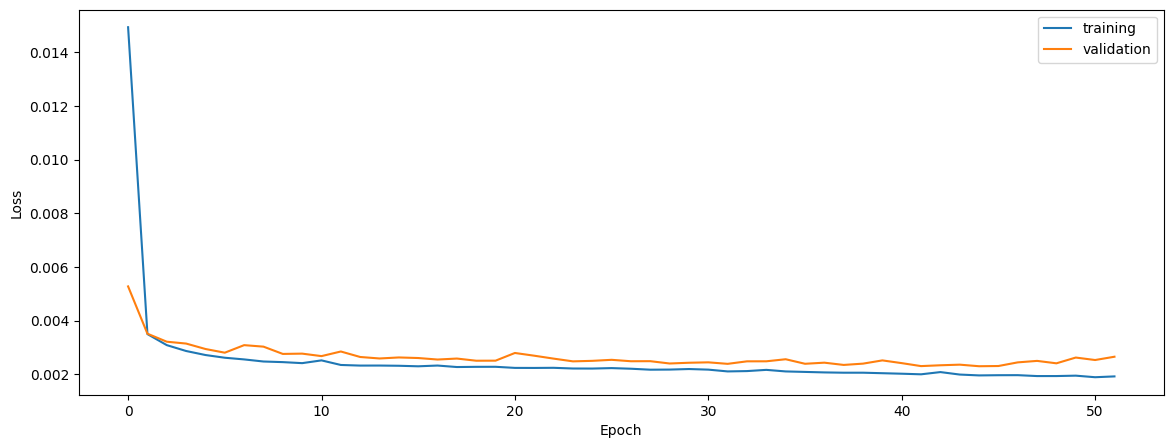

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9313329152267108
0.9223146506800128
0.9158401808448642


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9313329152267108
0.9223146506800128
0.9158401808448642


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.9436207243389761
0.934890159384295
0.9387778093184954


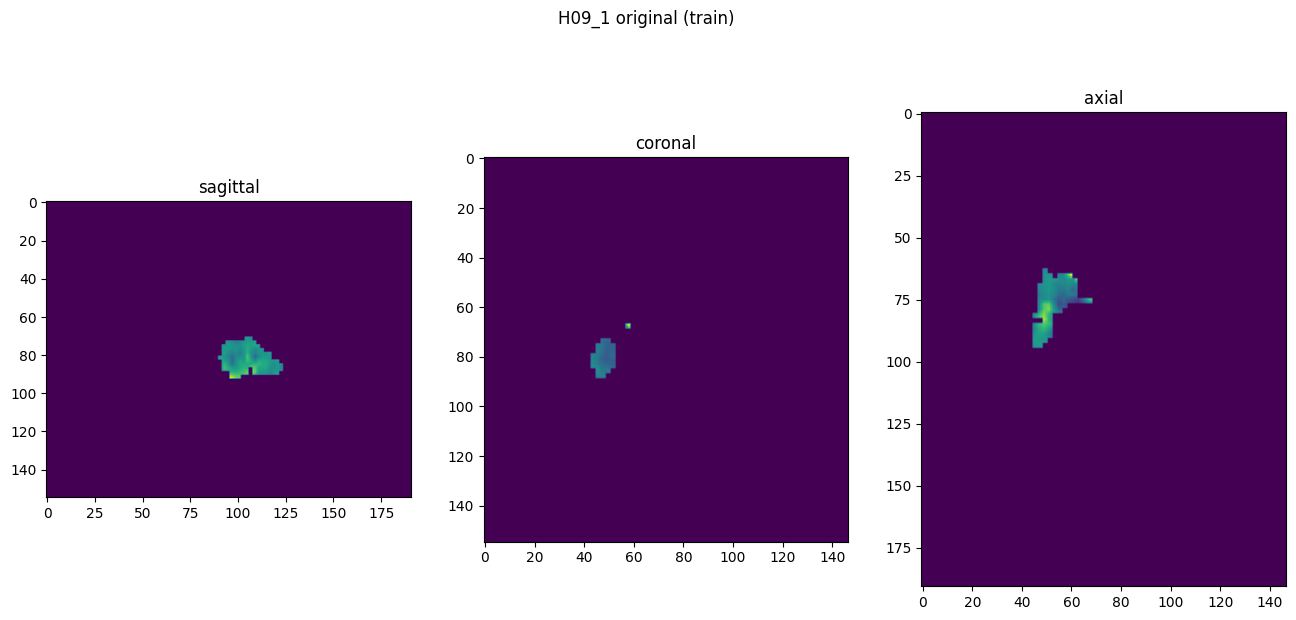

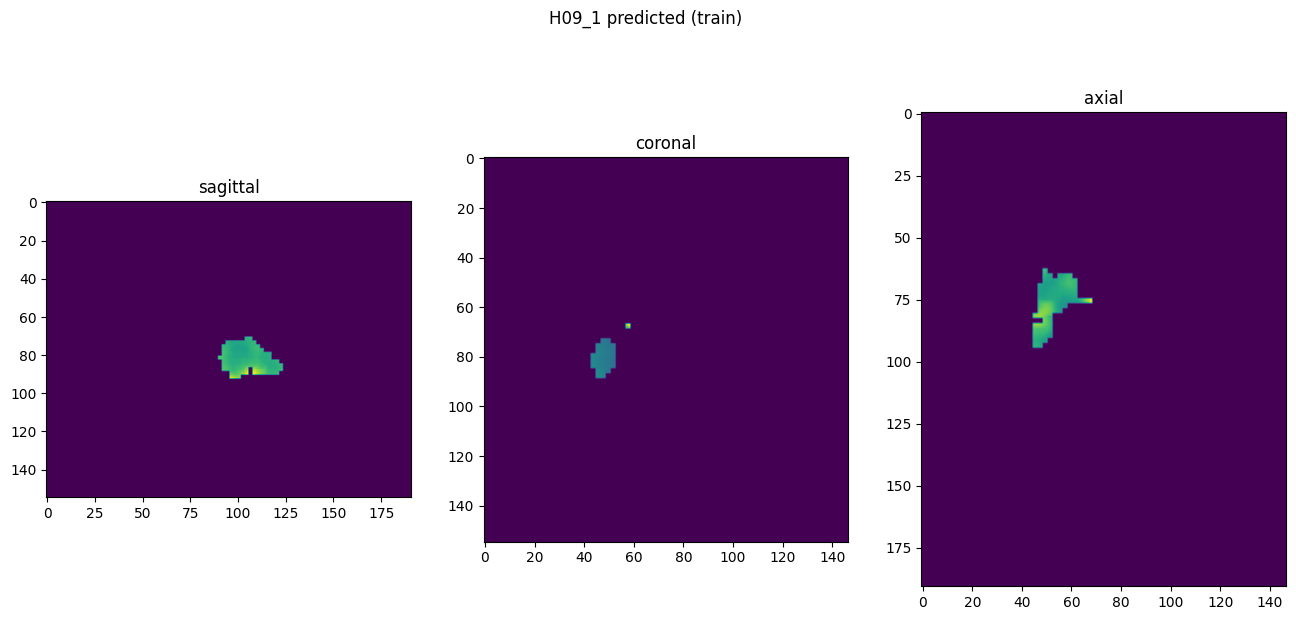

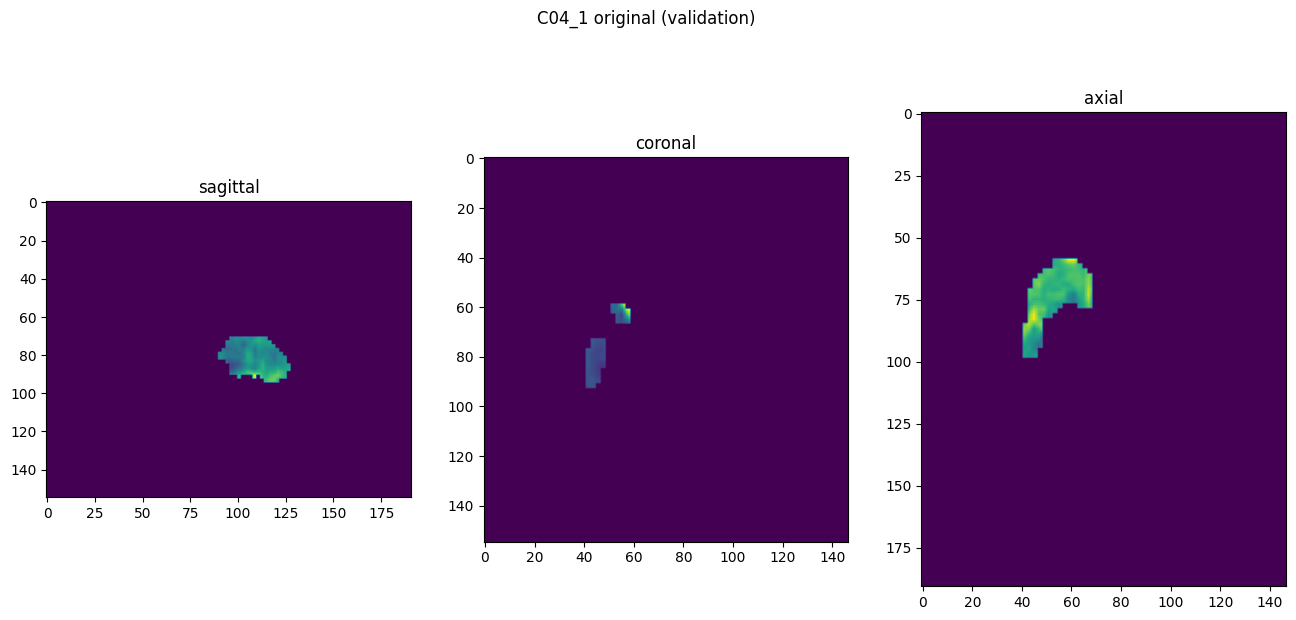

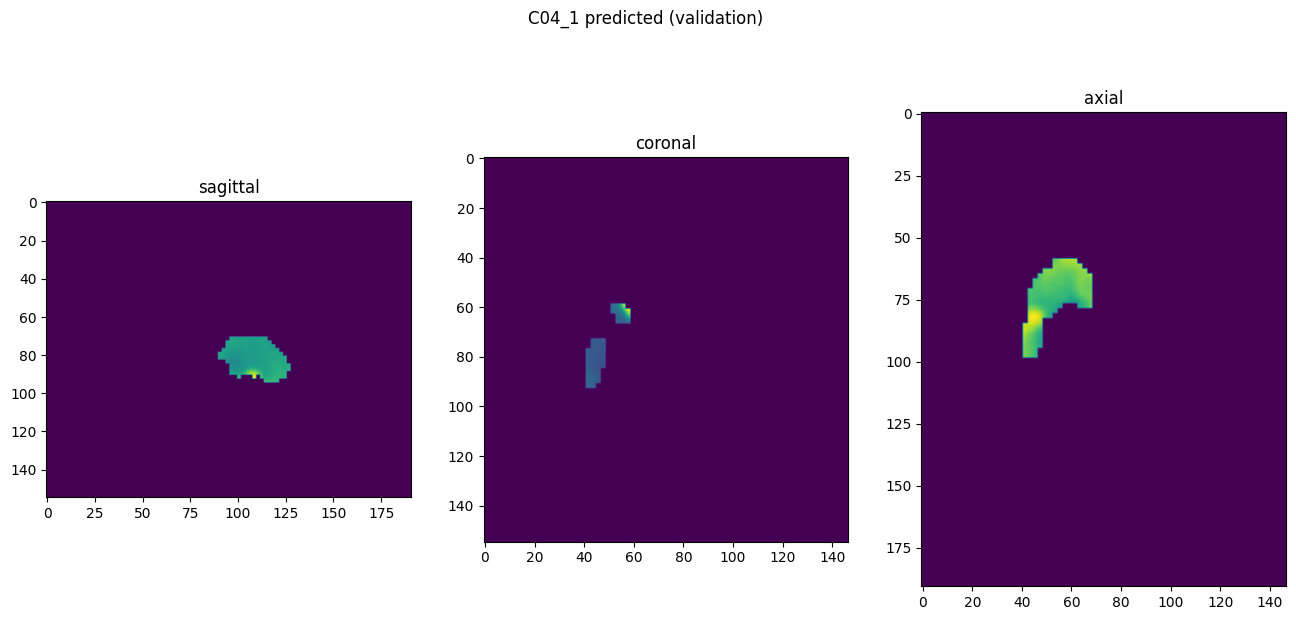

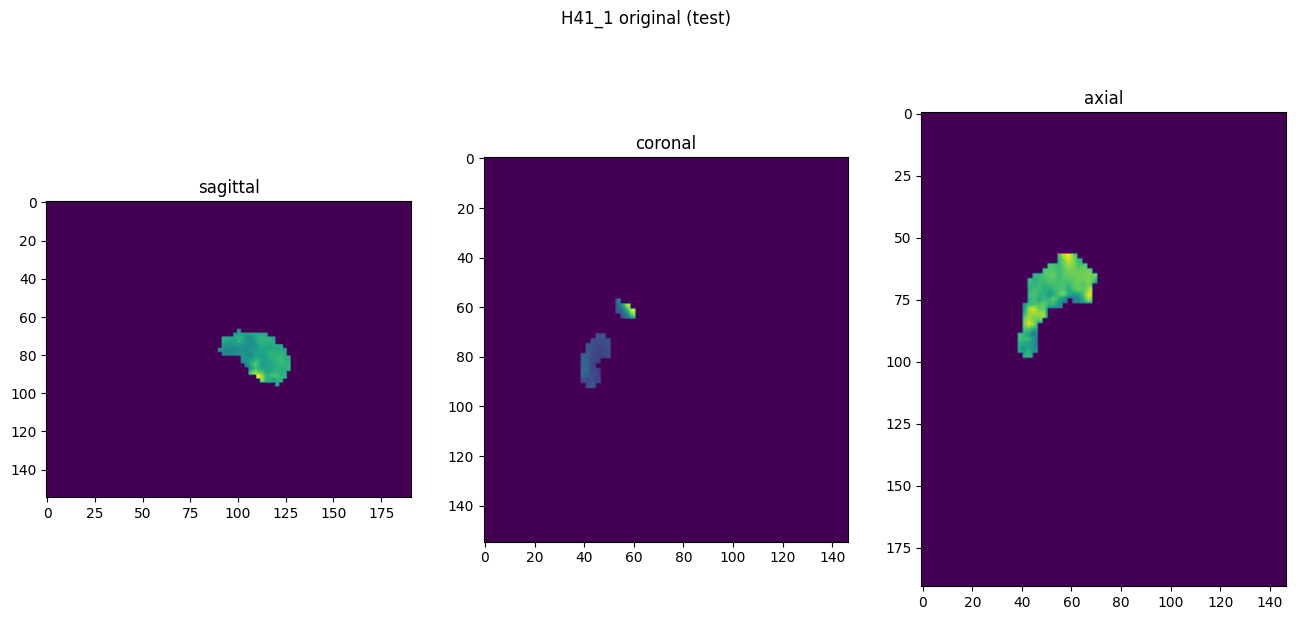

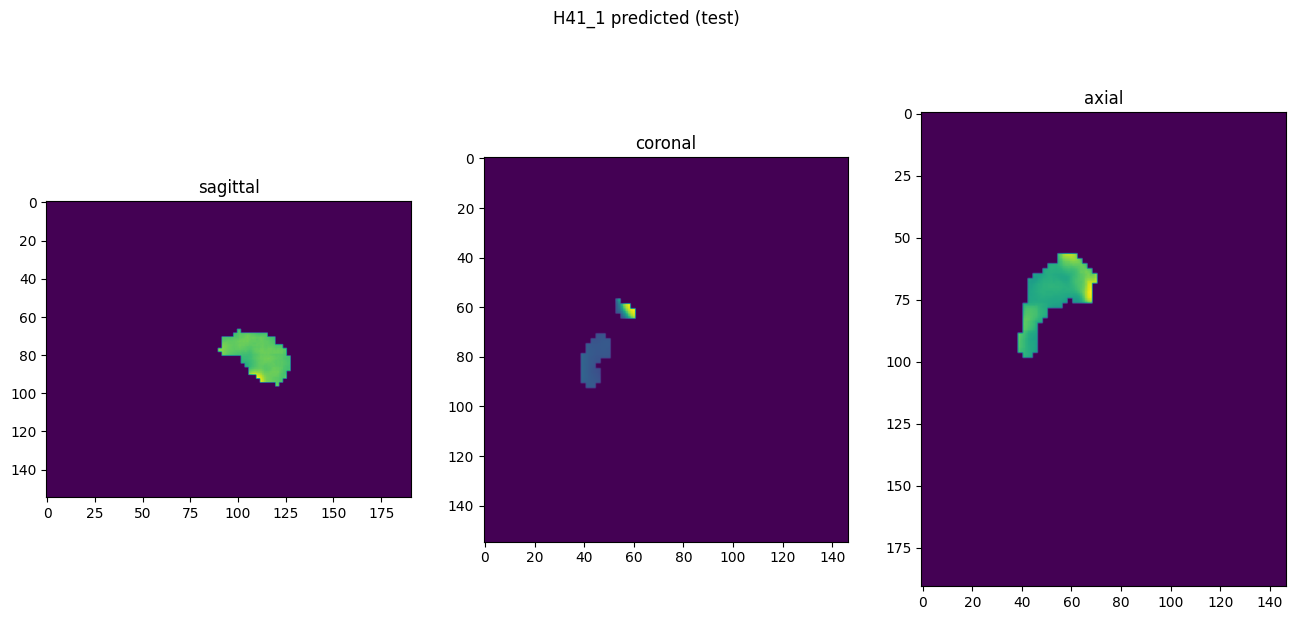

In [10]:
showResults(model, gen, threshold=None, background=False)